# TopoFun: a machine learning method to improve the functional similarity of gene co-expression modules
Ali Janbain<sup>1,2</sup>, Christelle Reynès<sup>1</sup>, Zainab Assaghir<sup>2</sup>, Hassan Zeineddine<sup>2</sup>, Robert Sabatier<sup>1</sup> and Laurent Journot<sup>1,3</sup>

<sup>1</sup>Institut de Génomique Fonctionnelle, IGF, Univ. Montpellier, CNRS, INSERM, Montpellier, 34094, France; <sup>2</sup>Faculté des Sciences, Université Libanaise, Beyrouth, Liban; <sup>3</sup>Montpellier GenomiX, MGX, Univ. Montpellier, CNRS, INSERM, Montpellier, 34094, France

## Table of contents

1. Introduction
2. Data  
   2.1 Mmu.c3.1.RData  
   2.2 gene.ids.RData  
   2.3 functional.similarity.scores.RData  
   2.4 results.LDA.RData  
   2.5 GO.gene.composition.RData  
3. Functions  
   3.1. constructNetwork  
   3.2. topologicalDescriptors  
   3.3. scaleScoreTopo  
   3.4. fitnessFunction  
   3.5. TopoFun  
   3.6. plotTopoFun  
4. Application to GO:0006413, 'translational initiation'

## 1. Introduction
TopoFun searches for genes co-expressed with an initial set of genes (seed genes), *e.g.* a Gene Ontology Biological Process (GO-BP), a gene family, a set of differentially expressed genes, a set of genes identified in a GWAS, a gene of interest and its neighbors in the co-expression network... Starting from the seed genes, TopoFun tests whether these genes, or a subset thereof, were significantly co-expressed, and explores the co-expression network to identify novel genes significantly co-expressed with the seed genes.  

We first performed LASSO (least absolute shrinkage and selection operator) to select the topological descriptors of gene co-expression modules that discriminated modules made of functionally related genes (functional modules, FMs) and modules made of randomly sampled genes (random modules, RMs). Using the selected topological descriptors, we performed Linear Discriminant Analysis to construct a topological score, *Score<sub>Topo</sub>*, that predicted the type of a module, random-like or functional-like.  

We combined the topological score and a functional similarity score, *Score<sub>Fun</sub>*, inspired by the work of Wang and co-workers (Wang J.Z. *et al.* (2007) A new method to measure the semantic similarity of GO terms. *Bioinformatics*, 23:1274-81) in a fitness function. Starting from a given gene set, we used a genetic algorithm to find genes whose co-expression with the largest clique of the gene set suggested that they may be functionally related. The TopoFun manuscript provides further details about the algorithm.

## 2. Data

### 2.1 Mmu.c3.1.RData
An RData file that contains the co-expression data of 20,959 murine genes from COXPRESdb Mmu.c3-1. It consists of 20,959 nodes and 10,901,364 edges with a mutual rank (MR) ≤ 1,200.
### 2.2 gene.ids.RData
An RData file that contains the 20,959 Gene IDs.
### 2.3 functional.similarity.scores.RData
An RData file that contains the functional similarity scores between the 20,959 genes. It is calculated from the Gene Ontology terms associated with the genes using the *geneSim* function of the GOSemSim package (https://rdrr.io/bioc/GOSemSim/man/geneSim.html).
### 2.4 results.LDA.RData
An RData file that contains the results of the Linear Discriminant Analysis. These data are used to predict the type of a network, random-like or functional-like.
### 2.5 GO.gene.composition.RData
An RData file that records which of the 20,959 genes are part of the 193 GO-BPs studied in the manuscript. It is composed of 20,959 rows (genes) and 193 columns (GO-BPs); each cell contains ‘1’ or ‘0’ depending on whether the gene is in the GO-BP or not.

## 3. Functions
### 3.1. constructNetwork :
**Description**  
The co-expression data from COXPRESdb Mmu.c3-1 consist of 20,959 text files. Each file contains the MR values between one specific gene and the 20,958 other genes in COXPRESdb. Each file’s name is the Gene ID of the specific gene. The file includes 3 columns and 20,958 rows.
- The first column contains the 20,958 Gene IDs.
- The second column contains the MR values between the specific gene and the 20,958 others.
- The third column contains the values of the Pearson correlation coefficient (PCC) between the specific gene and the 20,958 others.

The function extracts from COXPRESdb the network corresponding to a set of genes and a MR threshold. If the gene list includes all Gene IDs, the full network is constructed.

**Usage**  
constructNetwork(gene.ids, threshold, path)

**Argument**  
- gene.ids : a vector that contains the Gene IDs of the genes used to construct the subnetwork;
- threshold : the threshold value (µ in the manuscript) below which a MR is considered to denote co-expression. The default value is 1,200 (see the Supplementary File for a discussion about the default µ value);
- path : the path to the directory containing the 20,959 files of the COXPRESdb.

**Value**  
- coexp.Matrix : a 3-column matrix that describes the edges of the subnetwork. Each edge is characterized by 2 nodes (Gene IDs) and 1 MR value. The 2 first columns contain the Gene IDs and the third column contains the MR value;
- avgMutualRank : a 2-column matrix that contains the Gene IDs of the genes in the subnetwork and the corresponding average MR. These data are used for evaluation purpose only;
- coexp.Network : an igraph graph.

In [ ]:
# This function is used only once for each COXPRESdb network
# Do not run if the network was constructed and stored as an .RData file, e.g. Mmu.c3.1.RData

constructNetwork = function(gene.ids, threshold, path)
{
    gene.ids <- unique(gene.ids)
    nb.genes <- length(gene.ids)

    # Load the co-expression data
    setwd(path)
    coexp.data <- lapply(as.character(gene.ids), read.table)
    coexp.data <- data.frame(coexp.data)
    v1 <- c("ID", "Mutual_Rank", "COR")
    colnames(coexp.data) <- rep(v1, nb.genes)

    # Co-expression matrix; average mutual rank (= weigthed degree, for evaluation purpose only)
    coexp.mx = NULL
    avg.MR = NULL
    for(i in 1:nb.genes)
    {
        mx1 <- coexp.data[, c(3 * i - 2, 3 * i - 1)]
        mx2 <- cbind(gene.ids[i], mx1[, c(2, 1)])
        mx2 <- mx2[which(mx2[, 2] <= threshold),]
        mx2 <- mx2[-1,]
        mx3 <- mx2[which(mx2[, 3] %in% gene.ids),]
        coexp.mx <- rbind(coexp.mx, mx3)
        
        avg.MR[i] = NA
        if(length(mx3) >= 3) avg.MR[i] <- mean(mx3[, 2])
        
    }
    coexp.mx <- unique(t(apply(coexp.mx, 1, function(x) c(min(x[1], x[3]), x[2], max(x[1], x[3])))))
    row.names(coexp.mx) = NULL
    colnames(coexp.mx) <- c("ID", "Mutual_Rank", "ID")

    # Transform geneIDs to gene indices in the co-expression matrix
    coexp.mx.inds <- coexp.mx
    coexp.mx.inds[, 1] <- sapply(coexp.mx[, 1], function(z) which(gene.ids %in% z))
    coexp.mx.inds[, 3] <- sapply(coexp.mx[, 3], function(z) which(gene.ids %in% z))
    coexp.mx.inds <- unique(t(apply(coexp.mx.inds, 1, function(x) c(min(x[1], x[3]), x[2], max(x[1], x[3])))))
    colnames(coexp.mx.inds) <- colnames(coexp.mx)
    row.names(coexp.mx.inds) = NULL

    # Adjacency matrix
    adj.mx <- coexp.mx.inds[, c(1, 3)]
    adj.mx <- rbind(adj.mx, cbind(1:nb.genes, 1:nb.genes))

    # Construction of the network
    t.adj.mx <- as.vector(t(adj.mx))
    network <- graph(t.adj.mx, directed = FALSE)
    network <- simplify(network, remove.loops = TRUE)

    resultsConstructNetwork = NULL
    resultsConstructNetwork$coexp.Matrix <- coexp.mx
    resultsConstructNetwork$avgMutualRank <- avg.MR
    resultsConstructNetwork$coexp.Network <- network

    return(resultsConstructNetwork)

}

### 3.2. topologicalDescriptors :

**Description**  
Computes 12 topological descriptors of a network.

**Usage**  
topologicalDescriptors(network, relev = TRUE, nb.decim = 6)

**Argument**  
- network : the ‘coexp.Network’ output variable from the constructNetwork function;
- relev : a logical value, defaulting to TRUE, indicating whether the function computes the relevant descriptors only or all 12 descriptors;
- nb.decim : an integer indicating the number of decimal places to be used in the calculation.

**Value**  
Twelve descriptors calculated if relev = FALSE, and only the six relevant descriptors otherwise (see manuscript for the 12 descriptors).

In [ ]:
topologicalDescriptors = function(network, relev = TRUE, nb.decim = 6)
{
    # Size
    nb.vertices <- vcount(network)

    # Inverse centrality
    sh.path <- shortest.paths(network)
    inv.cent = NULL
    path <- 1 / sh.path
    inv.cent <- mean(path[!is.infinite(path)])

    # Average shortest path length
    avg.sh.path.length = NULL
    sh.path[sh.path == 0] = Inf
    pp <- rowMeans(sh.path * is.finite(sh.path), na.rm = TRUE)
    avg.sh.path.length <- sum(pp * is.finite(pp), na.rm = TRUE) / nb.vertices

    # Betweenness centrality
    btw.cent <- betweenness(network, normalized = TRUE) 
    avg.btw.cent <- mean(btw.cent) 

    # Average degree
    avg.degreee <- mean(degree(network))

    # Clustering coefficient
    clust.coef = NULL
    clust.coef <- transitivity(network, type = c("average"), isolates = c("zero"))

    resultsTopologicalDescriptors <- round(c(avg.sh.path.length, avg.btw.cent, avg.degreee, inv.cent, clust.coef, nb.vertices), nb.decim)
    names(resultsTopologicalDescriptors) <- c("AvgShortestPathLength", "BetweennessCentrality", "AvgDegree", "InverseCentrality", "ClusteringCoef", "Size")
    
    if(!relev)
    {
        # Neighborhood connectivity 
        nghb = NULL
        avg.nghb.degree = NULL
        nghb.connect = NULL
        for(i in 1:nb.vertices)
        {
            nghb <- neighbors(network, i)
            avg.nghb.degree[i] <- mean(degree(network)[nghb])
        }
        nghb.connect <- mean(avg.nghb.degree, na.rm = TRUE)

        # Radiality
        rad = NULL
        sh.path[is.infinite(sh.path)] <- NA
        diam <- diameter(network) 	 
        for (v in V(network)) rad[v] <- sum(diam + 1 - sh.path[v,], na.rm = TRUE) / (nb.vertices - 1) / diam
        avg.rad <- mean(rad)

        # Stress
        library(sna)
        adj.mx <- get.adjacency(network)
        adj.mx <- as(adj.mx, "matrix") 
        stress <- stresscent(adj.mx)
        avg.stress <- mean(stress) 
        detach("package:sna", unload = TRUE)

        # Topoligical coefficient
        topoCoef = function(network)
        {
            nb.vertices <- vcount(network)
            adj.mx <- get.adjacency(network)
            adj.mx <- as.matrix(adj.mx)

            if (nrow(adj.mx) != nb.vertices)
            {
                tra <- matrix(0, nb.vertices, nb.vertices)
                nplus <- 0
                nplus <- nb.vertices - nrow(adj.mx)
                tra <- bdiag(adj.mx, diag(nplus))
                p.mutal <- nb.vertices - seq(1:nplus) + 1
                tra[pmal, pmal] <- 0
                adj.mx <- as.matrix(tra)
            }

            J <- matrix(0, nb.vertices, nb.vertices)
            T = NULL

            for (i in 1:(nb.vertices - 1))
            for (j in (i + 1):nb.vertices)
            {
                wh1 <- which(adj.mx[i,] == adj.mx[j,])
                if (length(which(adj.mx[i, wh1] == 1)) != 0 )
                {
                    J[i, j] <- length(which(adj.mx[i, wh1] == 1)) + adj.mx[i, j]
                    J[j, i] <- J[i, j]
                }
            }
            for (i in 1:nb.vertices)
            { 
                if (sum(adj.mx[i,]) > 2)
                T[i] <- (sum(J[i,]) / length(which(J[i,] != 0))) / sum(adj.mx[i,])
                if (sum(adj.mx[i,]) <= 2)
                T[i] <- 0
                T[is.na(T)] <- 0
            }
                return(mean(T))
        }
        topo.coef <- topoCoef(network)

        # Eccentricity
        ecc <- eccentricity(network)
        avg.ecc <- mean(ecc)

        # Closeness
        closeness = NULL
        path = NULL
        path <- 1 / sh.path
        path[is.infinite(path)] <- 0 
        closeness <- mean(path, na.rm = TRUE)

        resultsTopologicalDescriptors <- round(c(avg.sh.path.length, closeness, avg.btw.cent, avg.degreee, avg.ecc, nghb.connect, avg.stress, avg.rad, topo.coef, inv.cent, clust.coef, nb.vertices), nb.decim)
        names(resultsTopologicalDescriptors) <- c("AvgShortestPathLength", "Closeness", "BetweennessCentrality", "AvgDegree", "Eccentricity", "NeighborhoodConnectivity", "Stress", "Radiality", "TopoligicalCoef", "InverseCentraility", "ClusteringCoef", "Size")
    }
    return(resultsTopologicalDescriptors)
}

### 3.3. scaleScoreTopo :

**Description**  
As mentioned in the manuscript, *Score<sub>Topo</sub>* ranged from -2.535 to +6.466 on the learning data set. We introduced *δ<sub>0</sub>* = 0.281608 and *δ<sub>1</sub>* = 0.1110948 to scale *Score<sub>Topo</sub>* using the learning dataset so that the RM with the lowest *Score<sub>Topo</sub>* was set to 0 and the FM with highest *Score<sub>Topo</sub>* was set to 1.

**Usage**  
scaleScoreTopo(scoretopo)

**Argument**  
- scoretopo: the value of *Score<sub>Topo</sub>*.
- d0 and d1: the scaling factors

**Value**  
The *Score<sub>Topo</sub>* value after scaling. It is the scaled.scoretopo variable used in the fitnessFunction below.

In [ ]:
scaleScoreTopo = function(scoretopo, d0 = 0.281608, d1 = 0.1110948)
    {
        scaled.scoretopo <- d0 + d1 * scoretopo
        return (scaled.scoretopo)
    }

### 3.4. fitnessFunction :
**Description**  
The TopoFun fitness function as defined in the manuscript. It is used in the fitnessValue function of TopoFun. It takes as input 3 values characterizing a potential solution produced by the genetic algorithm and returns a numerical value measuring its ‘fitness’.

**Usage**  
fitnessFunction(scaled.scoretopo, scorefun, m0.fraction)

**Argument**  
- scaled.scoretopo : *Score<sub>Topo</sub>* value after scaling by the scaleScoreTopo function;
- scorefun : *Score<sub>Fun</sub>* value;
- m0.fraction : the number of genes that belong to the module to evaluate, *M<sub>1</sub>*, and to the initial module, *M<sub>0</sub>*, divided by the number of genes in *M<sub>0</sub>*, *i.e.* |*M<sub>1</sub>*∩*M<sub>0</sub>*| / |*M<sub>0</sub>*|.

**Value**  
A numerical value that measures the ‘fitness’ of a solution.

In [ ]:
fitnessFunction = function(scaled.scoretopo, scorefun, m0.fraction)
    {
        fitness.value <- sqrt(scaled.scoretopo) * scorefun * m0.fraction
        return(fitness.value)
    }

### 3.5. TopoFun :

**Description**  
The TopoFun genetic algorithm

**Usage**  
TopoFun(  
 m0.ids,  
 all.gene.ids,  
 all.network,  
 fun.sim = functional.similarity.scores,  
 lda.output = results.LDA,  
 max.iter = 3000,  
 conv = 100,  
 m0.nghb.only = FALSE,   
 nghb.init = FALSE,    
 random.init = FALSE,  
 size.popA = 300,  
 size.popB = 100,  
 size.popC = 100,  
 max.gene = 500,   
 selection.method = "Tournament",  
 tourn = 2,  
 p.mut = 0.8,  
 p.cross = 0.5,  
 age.max = 10,  
 rejuv = 1)  
 
 **Argument**  
- m0.ids: a list of the Gene IDs in the initial *M<sub>0</sub>* gene set;
- all.gene.ids: a list of the Gene IDs of all genes in the COXPRESdb under study;
- all.network: an igraph object representing the relationships between all genes in COXPRESdb;
- fun.sim: a matrix containing the functional similarity scores between each pair of genes in the COXPRESdb;
- lda.output: the output of LDA function (lda(x, ...) as implemented in the MASS package) which seeks a linear combination of the topological descriptors that optimally discriminated functional and random modules. By default, results.LDA;
- max.iter: the maximum number of iterations to run before the algorithm search is halted, defaulting to 3,000;
- conv: the number of iterations during which the best solution remains the same to consider TopoFun has converged;
- m0.nghb.only: a logical variable defaulting to FALSE. When TRUE, TopoFun explores only the neighborhood of the initial gene set. At each iteration, the added genes are selected among the neighbors of the initial *M<sub>0</sub>* gene set whose degree to the *M<sub>0</sub>* genes is higher than average;
- nghb.init: a logical variable defaulting to FALSE. When TRUE, only the initial *M<sub>0</sub>* genes and their neighbors are used to generate the first population of solutions;
- random.init: a logical variable defaulting to FALSE. When TRUE, the solutions of the first iteration are composed of the largest clique of *M<sub>0</sub>* and randomly selected genes;
- size.popA: the size of the population of solutions identical to *M<sub>0</sub>*, defaulting to 300;
- size.popB: the size of the population of solutions composed of the largest clique of *M<sub>0</sub>* and 80% of the genes of *M<sub>0</sub>* in the complement of the largest clique, defaulting to 100;
- size.popC: the size of the population of solutions composed of all genes in *M<sub>0</sub>* and (500 - |*M<sub>0</sub>*|) random genes (not in *M<sub>0</sub>*), defaulting to 100;
- max.gene: the maximum number of genes in each solution, defaulting to 500;
- selection.method : a variable indicating which selection method is used, defaulting to "Tournament". Available methods are "Tournament" and "Rank";
- tourn: number of solutions used in the tournament selection;
- p.mut: the probability of mutation in a parent solution. By default, 0.8;
- p.cross: the probability of crossover between pairs of solutions. By default, 0.5;
- age.max: maximum number of iterations allowed for a solution, defaulting to 10. Solutions present in the population for age.max iterations are replaced by a new solution composed of the elitism genes and other genes from the rest of data;
- rejuv: the number of genes to add to rejuvenate the solution, default to 1.

**Value**
- pop1: the list of the average Fitness values of the solutions at each iteration;
- pop2: the list of the average ScoreTopo values of the solutions at each iteration;
- pop4: the list of the average Size of the solutions at each iteration;
- pop5: the list of the average ScoreFun values of the solutions in each iteration;
- pop6: the list of the average M0Fraction values of the solutions at each iteration, where M0Fraction is the last term of the fitnessFunction;
- m0.lc.vx: the genes of the largest clique of the M0 module;
- max.gene: the maximum number of genes in each module;
- iteration: the actual number of iterations performed by TopoFun;
- bestfitness: the best Fitness value at each iteration;
- mf: the solution with the best Fitness value at the final iteration;
- fitnessSummary: a matrix of the values of the criterion terms for the initial M0 module and the final Mf module.

In [ ]:
TopoFun = function( m0.ids,
                    all.gene.ids,
                    all.network,
                    fun.sim = functional.similarity.scores,
                    lda.output = results.LDA,
                    max.iter = 3000,
                    conv = 100,
                    m0.nghb.only = FALSE,
                    nghb.init = FALSE,
                    random.init = FALSE,
                    size.popA = 300,
                    size.popB = 100,
                    size.popC = 100,
                    max.gene = 500,
                    selection.method = "Tournament",
                    tourn = 2,
                    p.mut = 0.8,
                    p.cross = 0.5,
                    age.max = 10,
                    rejuv = 1
                  )
{
######### Preliminary functions #########

    ## Select genes randomly
    choicevar = function(vec, Pmaxloc, Posis, nreste)
    {
        vec <- rep(NA, Pmaxloc + 6)
        nbvar <- sample(1:nreste, 1)
        varsel <- sort(sample(Posis, nbvar))
        vec[7:(6 + nbvar)] <- varsel
        vec[4] <- nbvar
        vec[3] <- 0
        return(vec)
    }

    ## Delete a gene
    deletevar = function(vec)
    {
        choixsup <- sample(1:vec[4], 1)
        vec[6+choixsup] = NA
        vec[7:length(vec)] <- sort(vec[7:length(vec)], na.last = TRUE)
        vec[4] <- vec[4] - 1
        vec[3] <- 0
        return(vec)
    }

    ## Add a gene
    addvar = function(vec, Posis)
    {
        poss <- Posis
        pola <- vec[7:(6+vec[4])]
        poss <- poss[!is.element(poss,pola)]
        if(length(poss) != 0)
        {
            choixadd <- sample(poss, 1)
            vec[7 + vec[4]] <- choixadd
            vec[4] <- vec[4] + 1
            vec[7:length(vec)] <- sort(vec[7:length(vec)], na.last = TRUE)
            vec[3] <- 0
        }
        return(vec)
    }

    ## Replace a gene
    changevar = function(vec, Posis)
    {
        choixsup <- sample(1:vec[4], 1)
        ##choice of the variable to add among those which are not in the selection
        poss <- Posis
        pola <- vec[7:(6 + vec[4])]
        poss <- poss[!is.element(poss, pola)]
        if(length(poss) != 0)
        {
            choixadd <- sample(poss, 1)
            vec[6 + choixsup] <- choixadd
            vec[7:length(vec)] <- sort(vec[7:length(vec)], na.last = TRUE)
            vec[3] <- 0
        }
        return(vec)
    }

    ## Mutation
    mutation = function(vec, Posis = posis, Pmaxloc = max.gene, Fbarre = Fbarre, Fmax = Fmax, p.mut = p.mut)
    {
        enrsol <- vec

        pmloc <- 1 # if Fmax = Fbarre then all the solutions have the same fitness -> mutate
        if (enrsol[1] < Fbarre) pmloc <- p.mut  
        if (enrsol[1] >= Fbarre & Fmax != Fbarre) pmloc <- p.mut * ((Fmax - enrsol[1]) / (Fmax - Fbarre))
            mut <- runif(1, 0, 1)
            if (mut < pmloc)
            {
                typemut <- runif(1, 0, 1)
                if (vec[4] >1 & vec[4] < Pmaxloc)
                {
                    if (typemut < 0.5) return(changevar(vec, Posis))
                    else
                    {
                        if (typemut < 0.75) return(deletevar(vec))
                        else return(addvar(vec, Posis))
                    }
                }
                else
                {
                    if (vec[4] == 1)
                    {
                        if (typemut < 0.5) return(changevar(vec, Posis))
                        else return(addvar(vec, Posis))
                    }
                    else
                    {
                        if (typemut < 0.5) return(changevar(vec, Posis))
                        else return(deletevar(vec))
                    }
                }
            }
            else return(vec)
    }
    
    ## fitnessValue
    # The argument 'vec' is a vector of numbers that represents a module.
    # The six first elements store
        # the Fitness value
        # the scaled ScoreTopo value
        # the number of iterations since the last change in the genes stored in vec
        # the number of genes in the module, except the m0 largest clique
        # the ScoreFun value
        # the M0 fraction
    # the next max.gene elements store either the vertex ID of the genes in the module or NA
    
    fitnessValue = function(vec)
    {
        # get the vertex numbers of the genes in vec
        m1.vx <- unique(c(m0.lc.vx, vec[7:(6 + vec[4])]))
        # get the subgraph induced by m1
        m1.subgraph <- induced.subgraph(all.network, m1.vx)
        # compute the topological descriptors on m1 subgraph
        m1.descriptors <- topologicalDescriptors(m1.subgraph)
        # perform class prediction. p1$x is the LDA score of m1
        p1 <- predict(lda.output, newdata = m1.descriptors)
        # scale the LDA score
        scaled.scoretopo <- scaleScoreTopo(p1$x)
        scaled.scoretopo <- ifelse(scaled.scoretopo < 0, 0, scaled.scoretopo)

        # get the Gene IDs of the genes in indiv
        m1.ids <- as.character(all.gene.ids[m1.vx])
        # compute the size of m1
        size.m1 <- length(m1.vx)
        # get the functional similarity scores for each pair of genes in m1
        d <- fun.sim[m1.ids, m1.ids]
        d[is.na(d)] <- 0
        # compute the ScoreFun of m1
        scorefun <- sum(d[lower.tri(d, diag = FALSE)]) / (size.m1 * (size.m1 - 1))

        # compute the fraction of M0 genes in M1
        m0.fraction <- length(intersect(m0.vx, m1.vx)) / length(m0.vx)
    
        # compute the fitness value
        fitness.value <- fitnessFunction(scaled.scoretopo, scorefun, m0.fraction)
    
        #
        vec[1] <- fitness.value
        vec[2] <- scaled.scoretopo
        #vec[3] is the number of iterations since the last change in the genes stored in vec.
        #vec[4] is the size of m1 (without m0 largest clique).
        vec[5] <- scorefun
        vec[6] <- m0.fraction
        
        return(vec)
    }

######### TopoFun main section #########
    
    if(m0.nghb.only) print(paste("Warning! TopoFun will look for new genes among M0's neighbors only."))
    
    if(m0.nghb.only) nghb.init = FALSE
    
    if(nghb.init) m0.nghb.only = TRUE
    allthefiless99 <- all.gene.ids

    allthefiless00 <- all.gene.ids
    graphALL00 <- all.network
    
    if(m0.nghb.only) #To reduce the genes space
    {
        # get the indices of the Gene IDs in m0.ids
        m0.vx <- which(allthefiless00 %in% m0.ids)
        
        ng <- length(m0.vx)
        gg <- list(0, ng)
        for(i in 1:ng) gg[[i]] <- neighbors(graphALL00, m0.vx[i])
        tbt <- table(unlist(gg))
        aa <- which(tbt >= mean(tbt))
        testgenes1200 <- noquote(names(aa))
        testgenes1200 <- unique(c(testgenes1200, m0.vx))
        testgenes1200 <- as.numeric(testgenes1200)

        testgenes <- testgenes1200
        OtherGenesGo <- allthefiless00[testgenes]

        all.gene.ids <- unique(c(m0.ids, OtherGenesGo))
        genesallthefiless <- which(allthefiless00 %in% all.gene.ids)
        graphALLtest <- induced.subgraph(graphALL00, genesallthefiless)
        all.network <- graphALLtest
        allthefiless99 <- allthefiless00[genesallthefiless]
        all.gene.ids <- allthefiless99
    }

    genesALL <- 1:length(all.gene.ids)
    m0.vx <- which(all.gene.ids %in% m0.ids) 
    m0.subgraph <- induced.subgraph(all.network, m0.vx)
    m0.lc.vx <- m0.vx[largest.cliques(m0.subgraph)[[1]]]
    genesAntiCliqGO <- m0.vx[!is.element(m0.vx, m0.lc.vx)]
    genesAntiGO <- genesALL[!is.element(genesALL, m0.vx)]

    genesAntiCliq <- genesALL[!is.element(genesALL, m0.lc.vx)]
    posis <- genesAntiCliq
    nreste <- length(genesAntiCliq) ##number of remaining genes

    size.pop <- size.popA + size.popB + size.popC

    if(random.init) #we generate solutions by chance
    {
        pop <- matrix(NA, size.pop, 6 + max.gene)
        pop <- t(apply(pop, 1, choicevar, Pmaxloc = max.gene, Posis = posis, nreste = max.gene))
        pop <- t(apply(pop, 1, fitnessValue))
    }

    if(!random.init)
    {
        vecTN <- rep(NA, 6 + max.gene) 
        vecTN[4] <- length(genesAntiCliqGO)
        vecTN[7:(6 + vecTN[4])] <- genesAntiCliqGO
        pop_A <- matrix(rep(vecTN, each = size.popA), nrow = size.popA)
        pop_A <- matrix(rep(fitnessValue(pop_A[1,]), each = size.popA),nrow = size.popA)

        pop_B <- NULL
        for(PB in 1:size.popB)
        {
            vecTN <- rep(NA, 6 + max.gene) 
            nbrgenerestant <- length(genesAntiCliqGO) 
            vecTN[4] <- round(nbrgenerestant * 0.8)
            vecTN[7:(6 + vecTN[4])] <- sample(genesAntiCliqGO,round(nbrgenerestant * 0.8))
            pop_B <- rbind(pop_B, vecTN)
        }
        pop_B <- t(apply(pop_B, 1, fitnessValue))

        pop_C <- NULL
        for(PC in 1:size.popC)
        {
            vecTN <- rep(NA, 6 + max.gene)
            nbrgenerestant <- max.gene - length(m0.vx)
            addgenes <- min(nbrgenerestant, 10)
            vecTN[4] <- length(genesAntiCliqGO) + addgenes

            vecTN[7:(6 + vecTN[4])] <- c(genesAntiCliqGO, sample(genesAntiGO, addgenes))
            pop_C <- rbind(pop_C, vecTN)
        }
        pop_C <- t(apply(pop_C, 1, fitnessValue))

        pop <- rbind(pop_A, pop_B, pop_C)
        Sabc <- size.popA + size.popB + size.popC
        pop <- pop[1:Sabc,]
        popINITIAL <- pop
    }

    if(nghb.init)
    {
        pp <- which(allthefiless00 %in% all.gene.ids)
        for(i in 1:size.pop)
        {
            ccc <- 7:(6 + pop[i, 4])
            vvv <- pp[pop[i, ccc]]
            pop[i, ccc] <- vvv
        }

        all.gene.ids <- allthefiless00
        all.network <- graphALL00
        genesALL <- 1:length(all.gene.ids)
        m0.vx <- which(all.gene.ids %in% m0.ids) 
        m0.subgraph <- induced.subgraph(graphALL00, m0.vx)
        m0.lc.vx <- m0.vx[largest.cliques(m0.subgraph)[[1]]]
        genesAntiCliqGO <- m0.vx[!is.element(m0.vx, m0.lc.vx)]
        genesAntiGO <- genesALL[!is.element(genesALL, m0.vx)]

        genesAntiCliq <- genesALL[!is.element(genesALL, m0.lc.vx)]
        posis <- genesAntiCliq
        nreste <- length(genesAntiCliq)
        allthefiless99 <- allthefiless00
    }

    ### Plot
        ab1 <- min(pop[1, 1:2]) - 1
        ab2 <- max(pop[1, 1:2]) + 2
        col <- c("red", "green", "blue", "black", "pink") #adjustcolor("green3", alpha.f = 0.1)
        plot(c(0, max.iter), c(ab1, ab2), type = "n", ylim = c(-0.5, 1), xlab = "Number of iterations", ylab = "Values", cex.lab = 1.5)
        points(0, mean(pop[, 1]), pch = 1, col = "red", type = "o") #mean of fitness
        points(0, max(pop[, 1]), pch = 16, col = "red") #max of fitness
        points(0, mean(pop[, 2]), pch = 1, col = "green") #mean of LDA
        points(0, max(pop[, 2]), pch = 16, col = "green") #max of LDA
        points(0, mean(pop[, 4] + length(m0.lc.vx)) / max.gene, pch = 1, col = "blue") #mean of size
        points(0, max(pop[, 4] + length(m0.lc.vx)) / max.gene, pch = 16, col = "blue") #max of size

        points(0, mean(pop[, 5]), pch = 1, col = "black") #mean of beta
        points(0, max(pop[, 5]), pch = 16, col = "black") #max of beta

        points(0, mean(pop[, 6]), pch = 1, col = "pink") #mean of M0Fraction
        points(0, max(pop[, 6]), pch = 16, col = "pink") #max of M0Fraction


        legend("bottomright", 
                legend = c("BestFitness_max", "ScoreTopo_max", "Size_max", "ScoreFun_max", "M0Fraction_max"), 
                col = col,
                pch = 16, 
                lty = 0,
                pt.cex = c(rep(1, 5)), 
                inset = 0.02)

        legend("bottomleft", 
                legend = c("BestFitness_mean", "ScoreTopo_mean", "Size_mean","ScoreFun_mean","M0Fraction_mean"), 
                col = col,
                pch = 1, 
                lty = 0,
                pt.cex = c(rep(1, 5)), 
                inset = 0.02)

    cat(paste("Total No. of genes = ", length(all.gene.ids))) 
    cat("\n")
    cat(paste("GA | iteration = ", 0, "   |    MeanFitness = ", noquote(format(round(mean(pop[, 1]), 3), nsmall = 3)), "   |    BestFitness = ", noquote(format(round(max(pop[, 1]), 3), nsmall = 3))))
    cat("\n")

    list.pop1 <- list(0, max.iter)
    list.pop2 <- list(0, max.iter)
    list.pop4 <- list(0, max.iter)
    list.pop5 <- list(0, max.iter)
    list.pop6 <- list(0, max.iter)
    list.elitisme <- list(0, max.iter)
    pop[, 3] <- 0
    indivpos0 <- 1
    elitisme0 <- pop[indivpos0,]
    gene <- 1
    popFINAL = NULL
    bestfitness = NULL
    elitismeM1 <- 0
    conver <- 0
    convergence = FALSE

    while (gene <= max.iter & !convergence)
    {
        t1 <- Sys.time()

        # check stopping criteria
        indivpos <- which.max(pop[, 1])
        elitisme <- pop[indivpos,]

        ze0 <- elitisme0[7:(6 + elitisme0[4])]
        ze1 <- elitisme[7:(6 + elitisme[4])]
        su <- (sum(ze0 %in% ze1) + sum(ze1 %in% ze0)) / (length(ze0) + length(ze1))
        if(su == 1)
        { 
            conver <- conver + 1
            elitisme[3] <- elitisme[3] + 1
        }
        if(su < 1) conver <- 0
        if(conver == conv) convergence = TRUE
        elitisme0 <- elitisme
        pop[, 3] <- pop[, 3] + 1
        
    ######### Selection #########
        
        # Tournament
        if(selection.method == "Tournament")
        {
            newpop <- matrix(NA, 0, max.gene + 6)
            for (i in 1:size.pop)
            {
                particip <- sample(1:size.pop, tourn, replace = F)
                newpop <- rbind(newpop, pop[particip[which.max(pop[particip, 1])],])
            }
            pop <- newpop
        }

        # Rank
        if(selection.method != "Tournament")
        {
            M <- median(1:size.pop)
            a1 <- 2 / (size.pop * (3 * size.pop - 4 * M + 1))
            a2 <- 2 * (size.pop - 2 * M) / (size.pop * (3 * size.pop - 4 * M + 1))
            rang <- rank(pop[, 1], ties.method = "average")
            proba <- a2 + a1 * rang
            selec <- sample(1:size.pop, size.pop, replace = T, prob = proba)
            pop <- pop[selec,]
        }
        
    ######### Crossing-over #########
        nvpop <- pop
        Fbarre <- mean(nvpop[, 1])
        Fmax <- max(nvpop[, 1])    
        seqce <- sample(1:size.pop, size.pop)
        for (i in 1:(length(seqce) / 2))
        {
            soloc <- nvpop[seqce[(2 * i - 1):(2 * i)],]
            floc <- soloc[, 1]
            Fprim <- max(floc)

            pcloc <- 1
            if (Fprim < Fbarre) pcloc <- p.cross 

            if (Fprim  >= Fbarre & Fmax != Fbarre) pcloc <- p.cross * ((Fmax - Fprim) / (Fmax - Fbarre))

            cross <- runif(1, 0, 1)

            if (cross < pcloc)
            {
                # Cross at one position
                ptscrois <- sample(7:(7 + (min(soloc[, 4]) - 1)), 1)#!?
                fils1 <- soloc[1,]
                fils2 <- soloc[2,]
                fils1[7:ptscrois] <- soloc[2, 7:ptscrois]
                repdup <- duplicated(fils1[7:length(fils1)], incomparables = NA)#positions des duplic. sans les NA.
                fils1[7:length(fils1)] <- sort(c(unique(fils1[7:length(fils1)], incomparables = NA), rep(NA, sum(repdup))), na.last = TRUE)
                fils2[7:ptscrois] <- soloc[1, 7:ptscrois]
                repdup <- duplicated(fils2[7:length(fils2)], incomparables = NA)
                fils2[7:length(fils2)] <- sort(c(unique(fils2[7:length(fils2)], incomparables = NA), rep(NA, sum(repdup))), na.last = TRUE)

                # Compute the new parameters
                fils1[4] <- sum(!is.na(fils1[7:length(fils1)]))
                fils2[4] <- sum(!is.na(fils2[7:length(fils2)]))
                nvpop[seqce[(2 * i - 1):(2 * i)],] <- rbind(fils1,fils2)
                nvpop[seqce[(2 * i - 1):(2 * i)], 3] <- rep(0, 2) #migration
            }
        }
        
    ######### Mutation #########
        nvpop1 <- t(apply(nvpop, 1, mutation, Posis = posis, Pmaxloc = max.gene, Fbarre = Fbarre, Fmax = Fmax, p.mut = p.mut))
        pop <- nvpop1
        pop <- t(apply(pop, 1, fitnessValue))

    ######### Elistism #########
        pop = rbind(pop, elitisme)
        indivpos <- which.max(pop[, 1])
        elitisme <- pop[indivpos,]
        pop <- pop[1:size.pop,]

    ######### Rejuvenation ############
        pop <- rbind(pop, elitisme)
        agemax <- which(pop[, 3] >= age.max)	
        genesElitisme <- elitisme[7:(6 + elitisme[4])]
        Pimmig <- max.gene - length(m0.lc.vx) - elitisme[4]
        genesAntiElitisme <- genesAntiCliq[!is.element(genesAntiCliq, genesElitisme)]
        if(length(agemax) > 0)
        {
            for (i in agemax)
            {
                ploc <- rejuv
                newgenes <- sample(genesAntiElitisme, ploc)
                pop[i, 7:(elitisme[4] + ploc + 6)] <- c(genesElitisme, newgenes)
                pop[i, 4] <- length(c(genesElitisme, newgenes))
                pop[i, 3] <- 0
            }

            newpop <- pop[agemax,]
            if(length(agemax) == 1) newpop <- as.matrix(t(newpop))
            newpop <- t(apply(newpop, 1, fitnessValue))
            pop[agemax,] <- newpop
        }
        
    ######### #########
        sup <- which(pop[, 1] == min(pop[, 1]))
        for(elit in 1:length(sup)) pop[sup[elit],] <- elitisme

        list.elitisme[[gene]] <- elitisme


        ### Plot
            list.pop1[[gene]] <- mean(pop[, 1])
            list.pop2[[gene]] <- mean(pop[, 2])
            list.pop4[[gene]] <- mean(pop[, 4])
            list.pop5[[gene]] <- mean(pop[, 5])
            list.pop6[[gene]] <- mean(pop[, 6])


            points(gene, mean(pop[, 1]), pch = 1, col = "red") #mean of fitness
            points(gene, max(pop[, 1]), pch = 16, col = "red") #max of fitness
            points(gene, mean(pop[, 2]), pch = 1, col = "green") #mean of LDA
            points(gene, max(pop[, 2]), pch = 16, col = "green") #max of LDA
            points(gene, mean(pop[, 4] + length(m0.lc.vx)) / max.gene, pch = 1, col = "blue") #mean of size
            points(gene, mean(pop[, 4] + length(m0.lc.vx)) / max.gene, pch = 16, col = "blue") #max of size

            points(gene, mean(pop[, 5]), pch = 1, col = "black") #mean of beta
            points(gene, max(pop[, 5]), pch = 16, col = "black") #max of beta

            points(gene, mean(pop[, 6]), pch = 1, col = "pink") #mean of M0Fraction
            points(gene, max(pop[, 6]), pch = 16, col = "pink") #max of M0Fraction

        t2 <- Sys.time()

        cat(paste("GA | iteration = ", gene, "   |    MeanFitness = ", noquote(format(round(mean(pop[, 1]), 3), nsmall = 3)), "   |    BestFitness = ", 
        noquote(format(round(max(pop[, 1]), 3), nsmall = 3)),"   |    Size = ", elitisme[4] + length(m0.lc.vx)))

        cat("\n")
        elitismeM1 <- elitisme

        bestfitness <- c(bestfitness, elitisme[1])
        popFINAL <- pop
 
        iteration <- gene
        gene <- gene + 1
        if(difftime(t2, t1, unit = "sec") > 120) gene <- max.iter + 1
    }

    ######### Results #########

    #Mf		
    mf <- elitisme
    mf <- mf[-c(1:6)]
    mf <- mf[!is.na(mf)]
    mf <- c(m0.lc.vx,mf)
    mf <- which(allthefiless00 %in% allthefiless99[mf])

    PositionCorrection = function(value) #Position Correction
    {
        solution1 <- value
        solution1 <- solution1[-c(1:6)]
        solution1 <- solution1[!is.na(mf)]
        solution1 <- which(allthefiless00 %in% allthefiless99[solution1])
        return(solution1)
    }

    # Summary
    summaryTopoFun = function(FMinitial, FMfinal)
    {
        summaryy <- matrix(0, 2, 4)

        #M0
        FMinitial.subgraph <- induced.subgraph(graphALL00, FMinitial)
        FMinitial.descriptors <- topologicalDescriptors(FMinitial.subgraph)
        p1 <- predict(lda.output,newdata = FMinitial.descriptors)
        scaled.scoretopo <- scaleScoreTopo(p1$x)
        scaled.scoretopo <- ifelse(scaled.scoretopo<0, 0, scaled.scoretopo)

        size.FMinitial <- length(FMinitial)
        d <- fun.sim[FMinitial, FMinitial]
        d[is.na(d)] <- 0
        scorefun <- sum(d[lower.tri(d, diag = FALSE)]) / (size.FMinitial * (size.FMinitial - 1))
        m0.fraction = length(intersect(m0.vx, FMinitial)) / length(m0.vx)
        fitness.value <- sqrt(scaled.scoretopo) * scorefun * m0.fraction

        colnames(summaryy) <- c("Size", "ScoreTopo", "ScoreFun", "FitnessValue")
        rownames(summaryy) <- c("Initial_Module", "Final_Module")

        summaryy[1, 1] <- size.FMinitial
        summaryy[1, 2] <- scaled.scoretopo
        summaryy[1, 3] <- scorefun
        summaryy[1, 4] <- fitness.value

        #Mf
        FMfinal.subgraph <- induced.subgraph(graphALL00, FMfinal)
        FMfinal.descriptors <- topologicalDescriptors(FMfinal.subgraph)
        p1 <- predict(lda.output, newdata = FMfinal.descriptors)
        scaled.scoretopo <- scaleScoreTopo(p1$x)
        scaled.scoretopo <- ifelse(scaled.scoretopo < 0, 0, scaled.scoretopo)

        size.FMfinal <- length(FMfinal)
        d <- fun.sim[FMfinal, FMfinal]
        d[is.na(d)] <- 0
        scorefun <- sum(d[lower.tri(d, diag = FALSE)]) / (size.FMfinal * (size.FMfinal - 1))
        m0.fraction <- length(intersect(m0.vx, FMfinal)) / length(m0.vx)
        fitness.value <- sqrt(scaled.scoretopo) * scorefun * m0.fraction

        summaryy[2, 1] <- size.FMfinal
        summaryy[2, 2] <- scaled.scoretopo
        summaryy[2, 3] <- scorefun
        summaryy[2, 4] <- fitness.value
        return(summaryy)
    }

    m0.vx <- which(allthefiless00 %in% m0.ids) 
    fitnessSummary <- summaryTopoFun(FMinitial = m0.vx, FMfinal = mf)


    results.topofun = NULL
    results.topofun$pop1 <- list.pop1
    results.topofun$pop2 <- list.pop2
    results.topofun$pop4 <- list.pop4
    results.topofun$pop5 <- list.pop5
    results.topofun$pop6 <- list.pop6
    results.topofun$m0.lc.vx <- m0.lc.vx
    results.topofun$max.gene <- max.gene
    results.topofun$iteration <- iteration
    results.topofun$bestfitness <- bestfitness
    results.topofun$mf <- mf
    results.topofun$fitnessSummary <- fitnessSummary

    #print(Mf)
    cat("\n")
    cat("\n")
    cat("+-----------------------------------+\n")
    cat("|             TopoFun               |\n")
    cat("+-----------------------------------+\n\n")

    cat("+-----------------------------------+\n") 
    cat("\nTopoFun results: \n")
    cat("\n")
    cat(paste("Population size        = ", size.pop, "\n"))
    cat(paste("Maximal No. iterations = ", max.iter, "\n"))
    cat(paste("Actual No. iterations  = ", iteration, "\n"))
    cat(paste("Best Fitness           = ", round(fitnessSummary[2, 4], 7), "\n"))

    cat("+-----------------------------------+\n")  
    cat("\nTopoFun summary: \n")
    cat("\n")
    print(fitnessSummary)		
    return(results.topofun)
}

### 3.6. plotTopoFun
**Description**  
This function gives a plot of the best values found during the iterations of TopoFun.

**Usage**  
plotTopoFun(results.topofun)

**Argument**  
- results.topofun: TopoFun output

**Value**  
- the plot

In [ ]:
plotTopoFun = function(results.topofun)
{
    col <- c("red", "green", "blue", "black", "pink")
    plot(x = 1:length(results.topofun$bestfitness), y = results.topofun$bestfitness, col = col[1], type = "o", pch = 16, ylim = c(-0.5, 1), xlab = "Number of iterations", ylab = "Values", cex.lab = 1.5)
    points(x = 1:length(results.topofun$bestfitness), y = Filter(Negate(is.null), results.topofun$pop2), col = col[2], type = "o", pch = 16)
    points(x = 1:length(results.topofun$bestfitness), y = lapply(Filter(Negate(is.null), results.topofun$pop4), function(x) (x + length(results.topofun$m0.lc.vx)) / results.topofun$max.gene), col = col[3], type = "o", pch = 16)
    points(x = 1:length(results.topofun$bestfitness), y = Filter(Negate(is.null), results.topofun$pop5), col = col[4], type = "o", pch = 16)
    points(x = 1:length(results.topofun$bestfitness), y = Filter(Negate(is.null), results.topofun$pop6), col = col[5], type = "o", pch = 16)

    legend("bottomright",
    legend = c("BestFitness", "ScoreTopo", "Size", "ScoreFun", "M0Fraction"),
    col = col,
    pch = 16,
    lty = 1,
    pt.cex = c(rep(1, 5)),
    inset = 0.02)
}

# 4. Application

An application of the TopoFun script is provided in the next cells.

The next cell loads the required packages *'igraph'* and *'MASS'*

In [ ]:
# Load packages
library(igraph)
library(MASS)

The next cell loads the data that should be in the same folder as this Jupyter notebook.

In [ ]:
# Load data
load("gene.ids.RData")
load("results.LDA.RData")
load("Mmu.c3.1.RData")
load("functional.similarity.scores.RData")
load("GO.gene.composition.RData")

In the next cell, TopoFun will run on GO:0006413 (*'translational initiation'*), which includes 52 genes whose Gene IDs are in column 27 of the matrix 'GO.gene.composition'. To run TopoFun on another seed gene set, assign the list of Gene IDs to *M0*.

The script opens an R Graphics Device that displays the value of different parameters at each iteration. After the last iteration, the script prints a summary and the final plot, which, in this particular case, shows the convergence of the algorithm after 1,484 iterations.

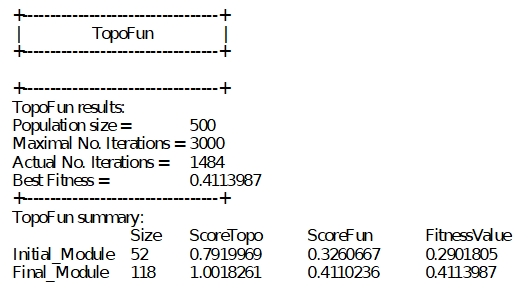

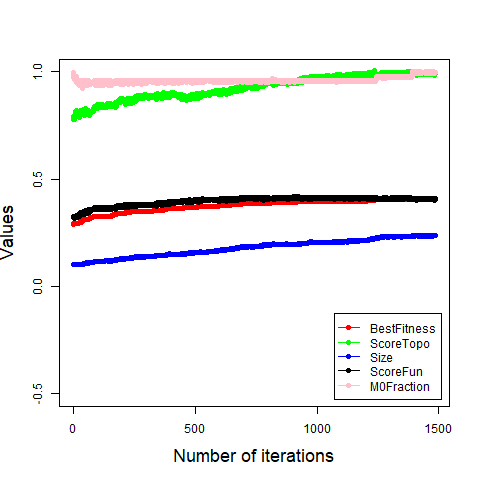

In [ ]:
# Get the M0 module = GO:0006413.
# If a different M0 module is to be analyzed, load it into M0.

ip <- 27
M0 <-  gene.ids[which(GO.gene.composition[,ip] == 1)]

#Run TopoFun on the M0 module
x11()
results.topofun <- TopoFun(
                    m0.ids = M0, 
                    all.gene.ids = gene.ids,
                    all.network = Mmu.c3.1,
                    fun.sim = functional.similarity.scores,
                    lda.output = results.LDA,
                    max.iter = 3000,
                    conv = 100,
                    m0.nghb.only = FALSE,
                    nghb.init = FALSE,
                    random.init = FALSE,
                    size.popA = 300,
                    size.popB = 100,
                    size.popC = 100,
                    max.gene = 500,
                    selection.method = "Tournament",
                    tourn = 2,
                    p.mut = 0.8,
                    p.cross = 0.5,
                    age.max = 10,
                    rejuv = 1
                    )

# Plot results
plotTopoFun(results.topofun)

# Get the final Mf module
mf.ids <- gene.ids[results.topofun$mf]

In [ ]:
# After convergence, save the plot as png
png("GO0006413_3000iter.png")
plotTopoFun(results.topofun)
dev.off()